In [1]:
import pandas as pd
import re
import unicodedata
import string
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

In [2]:
def load_dataset(file_path):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or Excel.")
    return df

# Example usage
file_path = "Spam_dataset.csv"  # or .xlsx
df = load_dataset(file_path)
text_column = "text"  

# Display the first few rows to verify
df.head()

,type,text
0,spam,জিঅ 5G গ্ৰাহকসকলৰ বাবে বিশেষ অফাৰ\nজিঅ এয়াৰফা...
1,spam,জিঅ'ফাইবাৰে আপোনাক স্বাস্থ্য আৰু ফিট্নেছ এপসমূ...
2,Ham,299.0 টকাৰ ৰিচাৰ্জ সফল হৈছে!\nJio নম্বৰ : 700...
3,spam,Jio 'ৰ সৈতে সংযুক্ত হৈ থাকক আৰু Jio 'ৰ বিশ্বমা...
4,spam,অতুলনীয় সেৱাৰ সৈতে ভাৰতৰ একমাত্ৰ প্ৰকৃত 5G নে...


In [3]:
# import re

# def extract_phone_numbers(df, text_column):
#     result_df = df.copy()
#     result_df['has_phone_number'] = 0
    
#     # Process each row
#     for idx, row in df.iterrows():
#         text = str(row[text_column])
        
#         # Convert Bengali/Assamese digits to Arabic digits for processing
#         bengali_assamese_text = text
#         digit_map = {
#             '০': '0', '১': '1', '২': '2', '৩': '3', '৪': '4',
#             '৫': '5', '৬': '6', '৭': '7', '৮': '8', '৯': '9'
#         }
        
#         for bn_digit, ar_digit in digit_map.items():
#             bengali_assamese_text = bengali_assamese_text.replace(bn_digit, ar_digit)
        
#         # Check for phone numbers (Indian format)
#         phone_patterns = [
#             r'\+?\d{2}\s*\d{10}',  # +91 XXXXXXXXXX or 91 XXXXXXXXXX
#             r'\d{3,5}[-\s]?\d{6,7}',  # XXX-XXXXXXX or XXXXX XXXXXX
#             r'\d{10,11}',  # XXXXXXXXXX (10 digits)
#             r'\d{2,4}[-\s]?\d{6,8}',  # Landline numbers: XX-XXXXXXXX or XXXX XXXXXXX
#             r'0\d{2,3}[-\s]?\d{6,8}',  # Landline with STD code: 0XX-XXXXXXXX
#             r'\d{3,4}\s+\d{2}\s+\d{5}',  # Pattern like "0222 33 55555"
#             r'\(\d{3,4}\)\s*\d{6,8}',  # Format like (033) 12345678
#             r'\+?\d{1,4}[-\s]?\d{2,4}[-\s]?\d{2,4}[-\s]?\d{2,4}'  # International format with separators
#         ]
        
#         # Check patterns in both original and converted text
#         has_phone = False
#         for pattern in phone_patterns:
#             if re.search(pattern, text) or re.search(pattern, bengali_assamese_text):
#                 has_phone = True
#                 break
        
#         # Additional check for Bengali/Assamese mix patterns (e.g., +৯১ ১২৩৪৫৬৭৮৯০)
#         mixed_patterns = [
#             r'\+?[০-৯\d]{2}\s*[০-৯\d]{10}',
#             r'[০-৯\d]{3,5}[-\s]?[০-৯\d]{6,7}',
#             r'[০-৯\d]{10,11}'
#         ]
        
#         if not has_phone:
#             for pattern in mixed_patterns:
#                 if re.search(pattern, text):
#                     has_phone = True
#                     break
        
#         if has_phone:
#             result_df.at[idx, 'has_phone_number'] = 1
    
#     return result_df

# # Apply phone number extraction
# df = extract_phone_numbers(df, text_column)

# # Display the count of messages with phone numbers
# print(f"Messages with phone numbers: {df['has_phone_number'].sum()}")

In [4]:
def extract_all_phone_numbers(df, text_column):
    """
    Creates a single column that flags rows containing any type of phone number (mobile or landline).
    
    Parameters:
    - df: pandas DataFrame containing the text data
    - text_column: name of the column containing text messages
    
    Returns:
    - Modified DataFrame with 'has_phone_number' column
    - Count of rows with any phone number
    """
    result_df = df.copy()
    
    # Digit mapping for Bengali/Assamese to Arabic digits
    digit_map = {
        '০': '0', '১': '1', '২': '2', '৩': '3', '৪': '4',
        '৫': '5', '৬': '6', '৭': '7', '৮': '8', '৯': '9'
    }
    
    # Comprehensive patterns for all phone numbers (mobile and landline)
    phone_patterns = [
        # Mobile patterns (10+ digits)
        r'\+?\d{2}\s*\d{10}',  # +91 XXXXXXXXXX or 91 XXXXXXXXXX
        r'\d{10,11}',  # XXXXXXXXXX (10 digits)
        r'\+?\d{1,4}[-\s]?\d{2,4}[-\s]?\d{2,4}[-\s]?\d{2,4}',  # International format with separators
        
        # Landline patterns (5-9 digits)
        r'\b\d{5,9}\b',  # Basic 5-9 digit numbers
        r'\b\d{2,5}[-\s]\d{3,5}\b',  # Format like 234-5678 or 2345 5678
        r'\(\d{2,4}\)[-\s]?\d{3,6}\b',  # Format like (022) 12345 or (022)12345
        r'\b0\d{2,4}[-\s]?\d{3,6}\b',  # Format like 022-12345 or 02212345
        r'\d{3,4}\s+\d{2}\s+\d{5}',  # Pattern like "0222 33 55555"
        r'\(\d{3,4}\)\s*\d{6,8}'  # Format like (033) 12345678
    ]
    
    # Mixed Bengali/Assamese patterns
    mixed_patterns = [
        r'\+?[০-৯\d]{2}\s*[০-৯\d]{10}',
        r'[০-৯\d]{3,5}[-\s]?[০-৯\d]{6,7}',
        r'[০-৯\d]{10,11}',
        r'\b[০-৯\d]{5,9}\b',  # Basic 5-9 digit numbers in Bengali/Assamese
        r'\b[০-৯\d]{2,5}[-\s][০-৯\d]{3,5}\b'  # Formatted like 234-5678 in Bengali/Assamese
    ]
    
    # Initialize the column if it doesn't exist
    if 'has_phone_number' not in result_df.columns:
        result_df['has_phone_number'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Convert Bengali/Assamese digits to Arabic digits for processing
        converted_text = text
        for bn_digit, ar_digit in digit_map.items():
            converted_text = converted_text.replace(bn_digit, ar_digit)
        
        # Check for phone numbers using all patterns
        has_phone = False
        
        # Check standard patterns in both original and converted text
        for pattern in phone_patterns:
            if re.search(pattern, text) or re.search(pattern, converted_text):
                # For landline patterns (5-9 digits), confirm length
                match = re.search(pattern, text) or re.search(pattern, converted_text)
                if match:
                    clean_match = re.sub(r'[-\s\(\)]', '', match.group())
                    # Valid phone if it's 10+ digits (mobile) or 5-9 digits (landline)
                    if len(clean_match) >= 5:
                        has_phone = True
                        break
        
        # If no match found, check mixed patterns
        if not has_phone:
            for pattern in mixed_patterns:
                if re.search(pattern, text):
                    match = re.search(pattern, text)
                    if match:
                        # Convert to Arabic numerals
                        clean_match = match.group()
                        for bn_digit, ar_digit in digit_map.items():
                            clean_match = clean_match.replace(bn_digit, ar_digit)
                        
                        # Remove non-digits
                        clean_match = re.sub(r'\D', '', clean_match)
                        # Valid if it's 5+ digits
                        if len(clean_match) >= 5:
                            has_phone = True
                            break
        
        # Update result
        if has_phone:
            result_df.at[idx, 'has_phone_number'] = 1
    
    # Calculate total phone number count
    total_phone_count = result_df['has_phone_number'].sum()
    
    return result_df, total_phone_count

# To use the function:
df, total_phone_count = extract_all_phone_numbers(df, text_column)
print(f"TOTAL NUMBER OF ROWS WITH PHONE NUMBERS: {total_phone_count}")

TOTAL NUMBER OF ROWS WITH PHONE NUMBERS: 286


In [5]:
def extract_special_chars(df, text_column):
    # Import string module if not already imported
    import string
    
    result_df = df.copy()
    result_df['has_special_chars'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for special characters
        special_chars = set(string.punctuation)
        # Remove specific characters one by one
        special_chars.discard('₹')
        special_chars.discard('?')
        special_chars.discard(',')
        special_chars.discard('.')
        
        if any(char in special_chars for char in text):
            result_df.at[idx, 'has_special_chars'] = 1
    
    return result_df

# Apply special character detection
df = extract_special_chars(df, text_column)

# Display the count of messages with special characters
print(f"Messages with special characters: {df['has_special_chars'].sum()}")

Messages with special characters: 2344


In [6]:
def extract_all_caps_words(df, text_column):
    result_df = df.copy()
    result_df['has_all_caps_words'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Consider only Latin script words (English)
        latin_words = re.findall(r'[A-Za-z]+', text)
        if latin_words and any(word.isupper() and len(word) > 1 for word in latin_words):
            result_df.at[idx, 'has_all_caps_words'] = 1
    
    return result_df

# Apply all caps words detection
df = extract_all_caps_words(df, text_column)

# Display the count of messages with all caps words
print(f"Messages with all capital words: {df['has_all_caps_words'].sum()}")

Messages with all capital words: 479


In [7]:
def extract_urls(df, text_column):
    result_df = df.copy()
    result_df['has_url'] = 0      # Flag for any type of URL
    result_df['has_short_url'] = 0 # Flag specifically for short URLs
    result_df['has_regular_url'] = 0 # New flag for regular (non-short) URLs
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for regular URLs
        regular_url_patterns = [
            r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+',  # http:// or https:// URLs
            r'www\.(?:[-\w.]|(?:%[\da-fA-F]{2}))+'       # www. URLs
        ]
        
        short_url_patterns = [
            r'bit\.ly/\S+', 
            r'goo\.gl/\S+', 
            r'tinyurl\.com/\S+',
            r't\.co/\S+'
        ]
        
        # Check for short URLs
        for pattern in short_url_patterns:
            if re.search(pattern, text):
                result_df.at[idx, 'has_short_url'] = 1
                result_df.at[idx, 'has_url'] = 1
                break
        
        # Check for regular URLs
        for pattern in regular_url_patterns:
            if re.search(pattern, text):
                # Check that this is not actually a match of a short URL
                match = re.search(pattern, text)
                matched_text = match.group(0)
                
                is_short_url = 0
                for short_pattern in short_url_patterns:
                    if re.search(short_pattern, matched_text):
                        is_short_url = 1
                        break
                
                if not is_short_url:
                    result_df.at[idx, 'has_regular_url'] = 1
                    result_df.at[idx, 'has_url'] = 1
                break
    
    return result_df

# Apply URL detection
df = extract_urls(df, text_column)

# Display the count of messages with URLs
print(f"Messages with any type of URL: {df['has_url'].sum()}")
print(f"Messages with short URLs: {df['has_short_url'].sum()}")
print(f"Messages with regular (non-short) URLs: {df['has_regular_url'].sum()}")
df = df.drop(['has_short_url', 'has_regular_url'], axis=1)

Messages with any type of URL: 426
Messages with short URLs: 192
Messages with regular (non-short) URLs: 257


In [8]:
def extract_mixed_language(df, text_column):
    import re
    import unicodedata
    
    result_df = df.copy()
    result_df['is_mixed_language'] = 0
    
    # URL regex pattern
    url_pattern = r'https?://\S+|www\.\S+'
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Remove URLs from the text for language detection purposes
        text_without_urls = re.sub(url_pattern, '', text)
        
        has_bengali_assamese = 0
        has_latin = bool(re.search(r'[A-Za-z]', text_without_urls))
        
        # Check for Bengali/Assamese script
        for char in text_without_urls:
            try:
                char_name = unicodedata.name(char, '')
                if 'BENGALI' in char_name or 'ASSAMESE' in char_name:
                    has_bengali_assamese = 1
                    break
            except ValueError:
                continue
        
        if has_bengali_assamese and has_latin:
            result_df.at[idx, 'is_mixed_language'] = 1
    
    return result_df

# Apply mixed language detection
df = extract_mixed_language(df, text_column)
# Display the count of messages with mixed language
print(f"Messages with mixed language: {df['is_mixed_language'].sum()}")

Messages with mixed language: 952


In [9]:
import re

def extract_currency(df, text_column):
    result_df = df.copy()
    result_df['has_currency'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for currency symbols and Western terms
        simple_patterns = [
            r'₹', r'रुपया', 
            r'Rs\.?', r'INR',
            r'\$', r'€', r'£', r'¥',
            r'dollar', r'euro', r'rupee'
        ]
        
        # Check simple patterns
        for pattern in simple_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                result_df.at[idx, 'has_currency'] = 1
                break
        
        # If currency already detected, skip to next row
        if result_df.at[idx, 'has_currency'] == 1:
            continue
        
        # Combined Bengali and Assamese currency terms
        currency_terms = [
            'টাকা', 'টকা', 'পয়সা', 'পোইসা', 'তাকা',
            'টকা', 'টাকা', 'পইচা', 'পাই', 'ধন',
            'taka', 'toka', 'poisa', 'paisa','টকীয়া'
        ]
        
        # Check for exact matches
        for term in currency_terms:
            if term in text:
                result_df.at[idx, 'has_currency'] = 1
                break
                
        # If still not detected, try with suffixes
        if result_df.at[idx, 'has_currency'] == 0:
            for term in currency_terms:
                pattern = term + r'\w*'
                if re.search(pattern, text):
                    result_df.at[idx, 'has_currency'] = 1
                    break
    
    return result_df

df = extract_currency(df, text_column)
print(f"Messages with Currency: {df['has_currency'].sum()}")

Messages with Currency: 608


In [10]:
import re

def extract_id_codes(df, text_column):
    result_df = df.copy()
    result_df['has_id_code'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Original pattern for ID codes (more than 10 digits)
        id_pattern1 = r'\b\w*\d{10,}\w*\b'
        
        # New pattern for format like R234321.1554.640085
        # Matches letter(s) followed by digits, then period, digits, period, digits
        id_pattern2 = r'\b[A-Za-z]+\d+\.\d+\.\d+\b'
        
        if re.search(id_pattern1, text) or re.search(id_pattern2, text):
            result_df.at[idx, 'has_id_code'] = 1
    
    return result_df

# Apply ID code detection
df = extract_id_codes(df, text_column)

# Display the count of messages with ID codes
print(f"Messages with ID codes: {df['has_id_code'].sum()}")

Messages with ID codes: 155


In [11]:
def extract_emojis(df, text_column):
    result_df = df.copy()
    result_df['has_emoji'] = 0
    
    # Import regex for emoji detection
    import re
    
    # Unicode ranges for emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0000257F"  # Enclosed characters
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002700-\U000027BF"  # Dingbats
        "\U0000FE0F"             # Variation Selector
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "]+", 
        flags=re.UNICODE
    )
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Check for emojis
        if emoji_pattern.search(text):
            result_df.at[idx, 'has_emoji'] = 1
    
    return result_df

# Apply emoji detection
df = extract_emojis(df, text_column)

# Display the count of messages with emojis
print(f"Messages with emojis: {df['has_emoji'].sum()}")

Messages with emojis: 47


In [12]:
import re
import unicodedata
import pandas as pd

def extract_dates(df, text_column):
    result_df = df.copy()
    result_df['has_date'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # Normalize Unicode to handle combining characters and diacritics properly
        text = unicodedata.normalize('NFC', text)
        
        # Check for dates in various formats
        date_patterns = [
            # DD/MM/YYYY, MM/DD/YYYY, YYYY/MM/DD
            r'\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}',
            
            # DD-MMM-YY format (e.g., 19-Jun-24)
            r'\d{1,2}-(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}',
            
            # NEW PATTERN: Ordinal with month abbreviation (e.g., 14th Feb.)
            r'\d{1,2}(?:st|nd|rd|th)?\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.?',
            
            # Bengali dates with months in words (with possible suffixes) - with optional comma
            r'\d{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর)(?:\w{0,3})?(?:,)?\s+\d{2,4}',
            
            # Assamese dates with months in words (with possible suffixes) - with optional comma
            r'\d{1,2}\s+(?:জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:\w{0,3})?(?:,)?\s+\d{2,4}',
            
            # Month name first in Bengali/Assamese (with possible suffixes)
            r'(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর)(?:\w{0,3})?\s+\d{1,2}(?:,)?\s+\d{2,4}',
            r'(?:জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:\w{0,3})?\s+\d{1,2}(?:,)?\s+\d{2,4}',
            
            # Text dates (English)
            r'\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{2,4}',
            r'\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{2,4}',
            
            # Month name first in English
            r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}(?:,)?\s+\d{2,4}',
            r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2}(?:,)?\s+\d{2,4}',
            
            # Year patterns
            r'\d{4}\s*সাল',  # Bengali year
            r'\d{4}\s*(?:year|বছর|বৰ্ষ)',  # Year in English or Bengali/Assamese
            
            # Bengali/Assamese numerals in dates
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}',
            
            # NEW PATTERN: Date with suffix followed by আগত (before) - pattern from new example
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:ৰ)?\s+আগত',
            
            # NEW PATTERN: Date with "তাৰিখে" followed by location
            r'\d{1,2}(?:st|nd|rd|th)?\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.?\s+তাৰিখে',
            
            # Date with তারিখ/তাৰিখ variations (date indicator)
            r'\d{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+\d{2,4}\s+(?:তারিখ(?:ে|ের|)|তাৰিখ(?:ে|ৰ|ত))',
            
            # Bengali numerals with তারিখ/তাৰিখ
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}\s+(?:তারিখ(?:ে|ের|)|তাৰিখ(?:ে|ৰ|ত))',
            
            # Day suffixes in Bengali/Assamese (ই, ৰ, র)
            r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি|যোৱা)\s+[১২৩৪৫৬৭৮৯০]{1,2}(?:ই|ৰ|র)?\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)',
            
            # Specific date format with দিন/দিনত (day)
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{2,4}\s+দিন(?:ত|ে)?',
            
            # Specific format with মাস/মাহ (month)
            r'(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)\s+মা(?:স|হ)',
            
            # Bengali/Assamese dates with specific date indicators
            r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি)\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:,)?\s+[১২৩৪৫৬৭৮৯০]{1,4}',
            
            # NEW PATTERN: Just month and day patterns (e.g., "১৬ মাৰ্চত")
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:ত|[[:punct:]])?',
            
            # Day and month followed by text and then year (to handle separated date components)
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ).*?[১২৩৪৫৬৭৮৯০]{4}',
            
            # Day and month in the context of events with year (দিৱস/event pattern)
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ).*?দিৱস.*?[১২৩৪৫৬৭৮৯০]{4}',
            
            # Specific pattern for International Migrant's Day type formats
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)\s+(?:".*?"|\'.*?\').*?[১২৩৪৫৬৭৮৯০]{4}',
        ]
        
        # Additional contextual patterns that may indicate dates
        context_patterns = [
            # Relative date expressions
            r'(?:আজি|আজ|কালি|কাল|গতকালি|গতকাল|পরশু|পৰহি|যোৱা)\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:দিন|দিনত)',
            r'(?:গত|বিগত|যোৱা|আহিবলগীয়া)\s+(?:সপ্তাহ|সপ্তাহত|সোমবাৰ|মঙ্গলবাৰ|বুধবাৰ|বৃহস্পতিবাৰ|শুক্ৰবাৰ|শনিবাৰ|ৰবিবাৰ|সোমবার|মঙ্গলবার|বুধবার|বৃহস্পতিবার|শুক্রবার|শনিবার|রবিবার)',
            
            # Date related day markers
            r'(?:সোমবাৰ|মঙ্গলবাৰ|বুধবাৰ|বৃহস্পতিবাৰ|শুক্ৰবাৰ|শনিবাৰ|ৰবিবাৰ|সোমবার|মঙ্গলবার|বুধবার|বৃহস্পতিবার|শুক্রবার|শনিবার|রবিবার)\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)',
            
            # NEW PATTERN: Holiday/festival day expressions
            r'উৎসৱমুখৰ\s+ছুটিৰ\s+দিনটো',
            
            # NEW PATTERN: Offer ending date with specific suffix
            r'অফাৰ\s+শেষ\s+হ\'ব\s+[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:ত|[[:punct:]])?',
            
            # NEW PATTERN: Cashback offer pattern with deadline
            r'(?:আগত|পূৰ্বে)\s+এমাহৰ\s+বাবে', 
            r'[১২৩৪৫৬৭৮৯০]{1,2}\s+(?:জান(?:ু|ূ)য়ার(?:ী|ি)|ফেব্র(?:ু|ূ)য়ার(?:ী|ি)|মার্চ|এপ্রিল|মে|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগস্ট|সেপ্টেম্বর|অক্টোবর|নভেম্বর|ডিসেম্বর|জান(?:ু|ূ)ৱার(?:ী|ি)|ফেব্র(?:ু|ূ)ৱার(?:ী|ি)|মাৰ্চ|এপ্ৰিল|জ(?:ু|ূ)ন|জ(?:ু|ূ)লাই|আগষ্ট|ছেপ্টেম্বৰ|অক্টোবৰ|নৱেম্বৰ|ডিচেম্বৰ)(?:ৰ)?\s+(?:আগত|পূৰ্বে)',
        ]
        
        date_found = False
        date_text = None
        
        # Check main date patterns
        for pattern in date_patterns:
            try:
                match = re.search(pattern, text, re.IGNORECASE)
                if match:
                    date_text = match.group(0)
                    result_df.at[idx, 'has_date'] = 1
                    date_found = True
                    break
            except Exception as e:
                print(f"Error with pattern: {pattern}")
                print(f"Error message: {e}")
                continue
        
        # If no date found yet, check context patterns
        if not date_found:
            for pattern in context_patterns:
                try:
                    match = re.search(pattern, text, re.IGNORECASE)
                    if match:
                        date_text = match.group(0)
                        result_df.at[idx, 'has_date'] = 1
                        break
                except Exception as e:
                    print(f"Error with context pattern: {pattern}")
                    print(f"Error message: {e}")
                    continue
    
    return result_df

# First, run this to add the 'has_date' column
df = extract_dates(df, 'text')  # Replace with your actual text column name
    
# Display the count of messages with dates
date_count = df['has_date'].sum()
print(f"Messages with date: {date_count}")

Messages with date: 440


C:\Users\VivoBook S 15 (2022)\AppData\Local\Temp\ipykernel_13396\1475420426.py:115: FutureWarning: Possible nested set at position 276
  match = re.search(pattern, text, re.IGNORECASE)
C:\Users\VivoBook S 15 (2022)\AppData\Local\Temp\ipykernel_13396\1475420426.py:130: FutureWarning: Possible nested set at position 296
  match = re.search(pattern, text, re.IGNORECASE)


In [13]:
import re
import pandas as pd

def extract_time(df, text_column):
    result_df = df.copy()
    result_df['has_time'] = 0
    
    # Process each row
    for idx, row in df.iterrows():
        text = str(row[text_column])
        
        # English time patterns
        english_patterns = [
            # 12-hour format with am/pm
            r'\b([0-9]|0[0-9]|1[0-2])(?::([0-5][0-9]))?(?::([0-5][0-9]))?\s*([AaPp][Mm])\b',
            # 12-hour variations with dot/space between numbers and am/pm
            r'\b([0-9]|0[0-9]|1[0-2])(?:\.|\s)([0-5][0-9])(?:\s*|\.)([AaPp]\.?[Mm]\.?)\b',
            # 24-hour format 
            r'\b([01]?[0-9]|2[0-3]):([0-5][0-9])(?::([0-5][0-9]))?\b',
            # Words like "noon", "midnight"
            r'\b(noon|midnight|midday)\b',
            # Time words with numbers
            r'\b([0-9]|0[0-9]|1[0-2])\s+o\'?clock\b',
            # Half and quarter phrasing
            r'\b(half|quarter)\s+(past|to)\s+([0-9]|0[0-9]|1[0-2])\b',
            # Hour variations
            r'\bat\s+([0-9]|0[0-9]|1[0-2])(?:\s+|\:)([0-5][0-9])?\s*([AaPp][Mm])?\b'
        ]
        
        # Bengali/Assamese time patterns (numeric)
        # Bengali digits: ০ ১ ২ ৩ ৪ ৫ ৬ ৭ ৮ ৯
        # Assamese digits: ০ ১ ২ ৩ ৪ ৫ ৬ ৭ ৮ ৯ (same as Bengali)
        bn_as_numeric_patterns = [
            # Hours and minutes with Bengali/Assamese digits
            r'[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)?[০-৯]{0,2}',
            # Hours with Bengali/Assamese digits followed by টা/বাজে/ঘণ্টা/घंटा
            r'[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা|घंटा)'
        ]
        
        # Bengali/Assamese time keywords
        bn_as_time_words = [
            # Time-related Bengali/Assamese words
            'সকাল', 'ভোর', 'রাত', 'বিকাল', 'সন্ধ্যা', 'দুপুর',  # Bengali time periods
            'ৰাতি', 'পুৱা', 'গধূলি', 'আবেলি', 'নিশা', 'দুপৰীয়া',  # Assamese time periods
            'টা', 'বাজে', 'ঘণ্টা', 'মিনিট', 'সেকেন্ড',  # Bengali units
            'বজি', 'বাজি', 'ঘণ্টা', 'মিনিট', 'ছেকেণ্ড'  # Assamese units
        ]
        
        # Combined approach for time detection
        time_detected = False
        
        # Check English patterns
        for pattern in english_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                result_df.at[idx, 'has_time'] = 1
                time_detected = True
                break
        
        if time_detected:
            continue
        
        # Check Bengali/Assamese numeric patterns
        for pattern in bn_as_numeric_patterns:
            if re.search(pattern, text):
                result_df.at[idx, 'has_time'] = 1
                time_detected = True
                break
        
        if time_detected:
            continue
        
        # Check for combination of Bengali/Assamese digits with time words
        if any(re.search(r'[০-৯]{1,2}\s*' + word, text) for word in bn_as_time_words):
            result_df.at[idx, 'has_time'] = 1
            time_detected = True
            continue
        
        # Check for time-related phrases
        # Bengali/Assamese phrases like "এখন ২টা বাজে" (It's 2 o'clock now)
        # or "সকাল ৯টা" (9 in the morning)
        time_phrases = [
            r'(?:এখন|বর্তমান|এতিয়া)\s+[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা|বজি)',
            r'(?:সকাল|ভোর|রাত|বিকাল|সন্ধ্যা|দুপুর|ৰাতি|পুৱা|গধূলি|আবেলি|নিশা|দুপৰীয়া)\s+[০-৯]{1,2}',
            r'[০-৯]{1,2}\s*(?:টা|বাজে|ঘণ্টা)\s*(?:ও|আৰু|এবং)?\s*[০-৯]{1,2}\s*(?:মিনিট|মিনিট)',
            # Early/late variations
            r'(?:ভোরে|ভোৰত|সকালে|সকালত|রাতে|ৰাতিত)\s+[০-৯]{1,2}',
            # AM/PM in Bengali/Assamese
            r'[০-৯]{1,2}(?:[:\.।]|\s*ঃ|\s+)[০-৯]{1,2}\s*(?:এএম|পিএম|am|pm|a\.m\.|p\.m\.)'
        ]
        
        for pattern in time_phrases:
            if re.search(pattern, text, re.IGNORECASE):
                result_df.at[idx, 'has_time'] = 1
                time_detected = True
                break
                
    return result_df

# Apply emoji detection
df = extract_time(df, text_column)

# Display the count of messages with emojis
print(f"Messages with time: {df['has_time'].sum()}")

Messages with time: 405


In [14]:
# Create a new column with the OR operation
df['date/time'] = df['has_date'] | df['has_time']

# Drop the original columns
df = df.drop(['has_date', 'has_time'], axis=1)

In [15]:
import pandas as pd
import re
from collections import Counter

def detect_repetitions(df, text_column):
    """
    Creates columns that flag texts containing:
    1. Repeated words
    2. Consecutive repeated special characters (like '???', '!!!', etc.)
    
    Parameters:
    - df: pandas DataFrame containing the text data
    - text_column: name of the column containing text messages
    
    Returns:
    - Modified DataFrame with new indicator columns
    - Counts of texts with repetitions
    """
    
    # Function to check if a text contains repeated words
    def has_repeated_words(text):
        if not isinstance(text, str):
            return 0
        
        # Remove punctuation but preserve Unicode characters for multilingual support
        text = re.sub(r'[^\w\s\u0980-\u09FF\u0985-\u09FB]', '', text.lower())
        
        # Split by whitespace to get words
        words = text.split()
        
        # Count occurrences of each word
        word_counts = Counter(words)
        
        # Check if any word appears more than once
        return 1 if any(count > 1 for count in word_counts.values()) else 0
    
    # Function to check if a text contains consecutive repeated special characters
    def has_consecutive_special_chars(text):
        if not isinstance(text, str):
            return 0
        
        # Pattern to find consecutive repeated special characters
        # This checks for 2 or more consecutive identical special characters
        # Removed inverted commas (single and double quotes) from the pattern
        special_chars_pattern = r'([\?\!\@\#\$\%\&\*\(\)\-\_\=\+\[\]\{\}\;\:\,\.\<\>\/\\\|])\1+'
        
        # Check if the pattern is found in the text
        if re.search(special_chars_pattern, text):
            return 1
        else:
            return 0
    
    # Apply the functions to create the new columns
    df['has_repeated_words'] = df[text_column].apply(has_repeated_words)
    df['has_consecutive_special_chars'] = df[text_column].apply(has_consecutive_special_chars)
    
    # Count the total numbers
    total_with_repeated_words = df['has_repeated_words'].sum()
    total_with_consecutive_special_chars = df['has_consecutive_special_chars'].sum()
    
    return df, total_with_repeated_words, total_with_consecutive_special_chars

# Example usage:
# 1. First load your dataset
# df = pd.read_csv('your_dataset.csv')
# 
# 2. Apply the function
df_result, word_count, special_count = detect_repetitions(df, 'text')
# 
# 3. Display the results
print(f"Total texts with repeated words: {word_count}")
print(f"Total texts with consecutive special characters: {special_count}")
#
# 4. Save the updated dataset
# df_result.to_csv('updated_dataset.csv', index=False)

Total texts with repeated words: 954
Total texts with consecutive special characters: 249


In [16]:
def detect_subscriber_codes(df, text_column):
    """
    Creates a column that flags rows containing subscriber codes in various formats:
    - 4 or 5 digit standalone numbers
    - USSD codes like *123#, *123*4#, etc.
    
    Parameters:
    - df: pandas DataFrame containing the multilingual text data
    - text_column: name of the column containing text messages
    
    Returns:
    - Modified DataFrame with new indicator column
    - Count of rows with subscriber codes
    """
    # Patterns to find different types of subscriber codes
    patterns = {
        'standalone_digits': r'\b\d{4,5}\b',  # 4-5 digit standalone numbers
        'ussd_code': r'\*\d+(?:\*\d+)*\#',    # USSD codes like *123#, *123*4#
        'hash_code': r'\#\d+(?:\*\d+)*\#?',   # Codes starting with # like #123
        'sms_code': r'\b[A-Za-z]+\s+\d+\b'    # Word followed by number like "SMS 12345"
    }
    
    # Function to check if a text contains subscriber codes
    def has_subscriber_code(text):
        if not isinstance(text, str):
            return 0
        
        # Handle special case where the code might be inside parentheses
        # Extract codes that might be in parentheses like (*3#)
        parentheses_pattern = r'\(([^\)]*)\)'
        parentheses_matches = re.findall(parentheses_pattern, text)
        
        # Check inside parentheses first
        for match in parentheses_matches:
            for pattern_name, pattern in patterns.items():
                if re.search(pattern, match):
                    return 1
        
        # Then check the entire text
        for pattern_name, pattern in patterns.items():
            matches = re.findall(pattern, text)
            if matches:
                return 1
        return 0
    
    # Apply the function to create the new column directly on the dataframe
    df['has_subscriber_code'] = df[text_column].apply(has_subscriber_code)
    
    # Count the total number of rows with subscriber codes
    total_with_subscriber_codes = df['has_subscriber_code'].sum()
    
    return df, total_with_subscriber_codes
df_result, total_codes = detect_subscriber_codes(df, 'text')
print(f"TOTAL NUMBER OF ROWS WITH SUBSCRIBER CODES: {total_codes}")


TOTAL NUMBER OF ROWS WITH SUBSCRIBER CODES: 717


In [17]:
# import pandas as pd
# import re
# from collections import Counter

# def detect_subscriber_codes(df, text_columns=None):
#     """
#     Creates a column that flags rows containing 4 or 5 digit subscriber codes
    
#     Parameters:
#     - df: pandas DataFrame containing the multilingual text data
#     - text_columns: list of column names to check for subscriber codes (if None, checks all columns)
    
#     Returns:
#     - Modified DataFrame with new indicator column
#     - Count of rows with subscriber codes
#     """
    
#     # If no specific columns are provided, check all columns
#     if text_columns is None:
#         text_columns = df.columns
    
#     # Pattern to find 4 or 5 digit numbers
#     pattern = r'\b\d{4,5}\b'
    
#     # Function to check if a row contains subscriber codes in any specified column
#     def has_subscriber_code(row):
#         for column in text_columns:
#             if column in row.index and isinstance(row[column], str):
#                 if re.search(pattern, row[column]):
#                     return 1
#         return 0
    
#     # Apply the function to create the new column
#     df['has_subscriber_code'] = df.apply(has_subscriber_code, axis=1)
    
#     # Count the total number of rows with subscriber codes
#     total_with_subscriber_codes = df['has_subscriber_code'].sum()
    
#     return df, total_with_subscriber_codes

# # Example usage:
# # 1. First load your dataset
# # df = pd.read_csv('your_dataset.csv', encoding='utf-8')
# #
# # 2. Apply the function
# df_result, code_count = detect_subscriber_codes(df)
# #
# # 3. Display the results
# print(f"Total rows with subscriber codes: {code_count}")
# #
# # 4. Save the updated DataFrame (optional)
# # df_result.to_csv('processed_dataset.csv', encoding='utf-8', index=False)

In [18]:
def calculate_avg_word_length(df, text_column):
    """
    Creates a column with the average word length for each text entry
    
    Parameters:
    - df: pandas DataFrame containing the text data
    - text_column: name of the column containing text messages
    
    Returns:
    - Modified DataFrame with new average word length column
    - Average word length across all texts
    """
    # Function to calculate average word length for a single text
    def avg_word_length(text):
        if not isinstance(text, str) or len(text.strip()) == 0:
            return 0.0
        
        # Remove punctuation but preserve Unicode characters for multilingual support
        # This handles English, Assamese, Bengali, and other scripts
        text = re.sub(r'[^\w\s\u0980-\u09FF\u0985-\u09FB]', '', text)
        
        # Split by whitespace to get words
        words = [word for word in text.split() if len(word) > 0]
        
        if not words:
            return 0.0
        
        # Calculate average word length using the formula:
        # sum of individual word lengths / total number of words
        total_length = sum(len(word) for word in words)
        total_words = len(words)
        
        # Apply the formula
        avg_length = total_length / total_words
        
        return round(avg_length, 2)
    
    # Apply the function to create the new column
    df['avg_word_length'] = df[text_column].apply(avg_word_length)
    
    # Calculate the overall average word length across all texts
    overall_avg = round(df['avg_word_length'].mean(), 2)
    
    return df, overall_avg
df_result= calculate_avg_word_length(df,text_column)

df.head()

,type,text,has_phone_number,has_special_chars,has_all_caps_words,has_url,is_mixed_language,has_currency,has_id_code,has_emoji,date/time,has_repeated_words,has_consecutive_special_chars,has_subscriber_code,avg_word_length
0,spam,জিঅ 5G গ্ৰাহকসকলৰ বাবে বিশেষ অফাৰ\nজিঅ এয়াৰফা...,0,1,1,1,1,1,0,0,0,1,0,1,4.95
1,spam,জিঅ'ফাইবাৰে আপোনাক স্বাস্থ্য আৰু ফিট্নেছ এপসমূ...,0,1,0,1,0,1,0,0,0,1,0,0,5.58
2,Ham,299.0 টকাৰ ৰিচাৰ্জ সফল হৈছে!\nJio নম্বৰ : 700...,1,1,1,1,1,1,1,0,0,1,1,0,7.83
3,spam,Jio 'ৰ সৈতে সংযুক্ত হৈ থাকক আৰু Jio 'ৰ বিশ্বমা...,0,1,0,0,1,0,0,0,0,1,0,0,3.85
4,spam,অতুলনীয় সেৱাৰ সৈতে ভাৰতৰ একমাত্ৰ প্ৰকৃত 5G নে...,0,1,0,0,1,1,0,0,0,1,0,0,4.70


In [19]:
# import re
# import pandas as pd

# def detect_landline_numbers(df, text_column):
#     """
#     Creates a column that flags rows containing landline phone numbers (less than 10 digits).
    
#     Parameters:
#     - df: pandas DataFrame containing the text data
#     - text_column: name of the column containing text messages
    
#     Returns:
#     - Modified DataFrame with updated has_phone_number column
#     - Count of rows with landline numbers
#     """
#     # Patterns to find different types of landline numbers
#     # Looking for numbers with less than 10 digits but at least 5 digits
#     # Avoiding 4-digit numbers as they might be confused with subscriber codes
#     patterns = {
#         'basic_landline': r'\b\d{5,9}\b',  # Basic 5-9 digit numbers
#         'formatted_landline': r'\b\d{2,5}[-\s]\d{3,5}\b',  # Format like 234-5678 or 2345 5678
#         'area_code_landline': r'\(\d{2,4}\)[-\s]?\d{3,6}\b',  # Format like (022) 12345 or (022)12345
#         'std_code_landline': r'\b0\d{2,4}[-\s]?\d{3,6}\b',  # Format like 022-12345 or 02212345
#     }
    
#     # Function to check if a text contains landline numbers
#     def has_landline_number(text):
#         if not isinstance(text, str):
#             return 0
        
#         for pattern_name, pattern in patterns.items():
#             matches = re.findall(pattern, text)
#             if matches:
#                 # Filter out matches that might be dates or other numeric patterns
#                 for match in matches:
#                     # Remove any separators to get just the digits
#                     clean_match = re.sub(r'[-\s\(\)]', '', match)
#                     # Check if the clean match is a valid length for a landline
#                     if 5 <= len(clean_match) <= 9:
#                         return 1
#         return 0
    
#     # Apply the function to create a column marking rows with landline numbers
#     df['has_landline_number'] = df[text_column].apply(has_landline_number)
    
#     # Count the total number of rows with landline numbers
#     total_with_landline_numbers = df['has_landline_number'].sum()
    
#     # Update the original has_phone_number column
#     # Note: This won't replace existing 1s in has_phone_number,
#     # but adds 1s for landline numbers that were previously missed
#     df['has_phone_number'] = df[['has_phone_number', 'has_landline_number']].max(axis=1)
    
#     # Calculate how many new phone numbers were detected
#     new_phone_numbers_detected = df['has_phone_number'].sum() - df['has_phone_number'].sum() + total_with_landline_numbers
    
#     return df, total_with_landline_numbers, new_phone_numbers_detected

# # Apply the function to the dataset
# df_result, total_landlines, new_detected = detect_landline_numbers(df, 'text')
# print(f"TOTAL NUMBER OF ROWS WITH LANDLINE NUMBERS: {total_landlines}")


In [20]:
def count_chars_without_spaces(text):
    """
    Count the number of characters in a text while ignoring spaces.
    Works for English, Assamese, Bengali, and other languages.
    
    Args:
        text (str): Input text in any language
        
    Returns:
        int: Number of characters excluding spaces
    """
    if not isinstance(text, str):
        return 0
    
    # Count all characters except spaces
    return sum(1 for char in text if char != ' ')

def word_length(df, text_column):
    """
    Process a dataframe by adding a column with character count (excluding spaces)
    for messages in the specified text column.
    
    Args:
        df (pandas.DataFrame): Input dataframe containing messages
        text_column (str): Name of the column containing text messages
        
    Returns:
        pandas.DataFrame: Original dataframe with added 'word_length' column
    """
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Apply the function to create the new column
    result_df['word_length'] = result_df[text_column].apply(count_chars_without_spaces)
    
    return result_df

# Example usage
# df_result = word_length(df, text_column)  # This creates a new dataframe
# Instead, you should either:

# Option 1: Assign the result back to df
df = word_length(df, 'text')  # Replace 'text_column_name' with your actual column name
df.head()

# OR

# Option 2: Use df_result for subsequent operations
df_result = word_length(df, 'text')  # Replace 'text_column_name' with your actual column name
df_result.head()

,type,text,has_phone_number,has_special_chars,has_all_caps_words,has_url,is_mixed_language,has_currency,has_id_code,has_emoji,date/time,has_repeated_words,has_consecutive_special_chars,has_subscriber_code,avg_word_length,word_length
0,spam,জিঅ 5G গ্ৰাহকসকলৰ বাবে বিশেষ অফাৰ\nজিঅ এয়াৰফা...,0,1,1,1,1,1,0,0,0,1,0,1,4.95,118
1,spam,জিঅ'ফাইবাৰে আপোনাক স্বাস্থ্য আৰু ফিট্নেছ এপসমূ...,0,1,0,1,0,1,0,0,0,1,0,0,5.58,268
2,Ham,299.0 টকাৰ ৰিচাৰ্জ সফল হৈছে!\nJio নম্বৰ : 700...,1,1,1,1,1,1,1,0,0,1,1,0,7.83,361
3,spam,Jio 'ৰ সৈতে সংযুক্ত হৈ থাকক আৰু Jio 'ৰ বিশ্বমা...,0,1,0,0,1,0,0,0,0,1,0,0,3.85,80
4,spam,অতুলনীয় সেৱাৰ সৈতে ভাৰতৰ একমাত্ৰ প্ৰকৃত 5G নে...,0,1,0,0,1,1,0,0,0,1,0,0,4.70,160



Feature Summary:
has_phone_number: 286 instances
has_special_chars: 2344 instances
has_all_caps_words: 479 instances
has_url: 426 instances
is_mixed_language: 952 instances
has_currency: 608 instances
date/time: 788 instances
has_id_code: 155 instances
has_emoji: 47 instances
has_repeated_words: 954 instances
has_subscriber_code: 717 instances


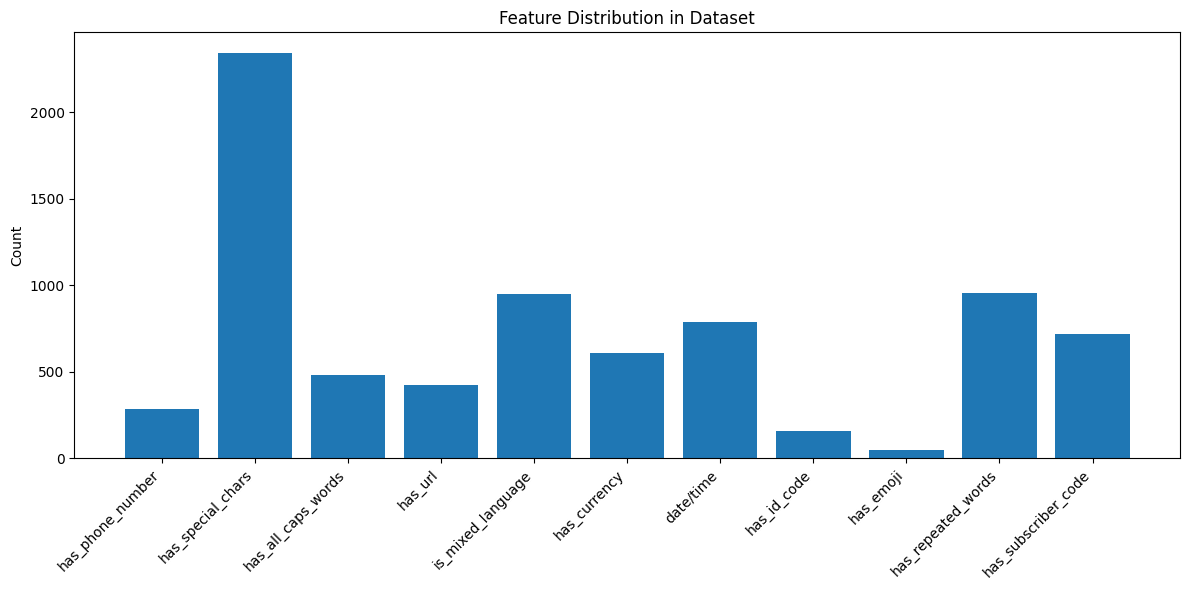

In [21]:
def generate_summary(df):
    feature_columns = [
        'has_phone_number', 'has_special_chars', 'has_all_caps_words','has_url', 
        'is_mixed_language',
        'has_currency', 'date/time', 'has_id_code','has_emoji','has_repeated_words','has_subscriber_code'
    ]
    
    summary = {col: df[col].sum() for col in feature_columns}
    
    print("\nFeature Summary:")
    for feature, count in summary.items():
        print(f"{feature}: {count} instances")
    
    # Plot the summary
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.bar(summary.keys(), summary.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Distribution in Dataset')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Generate and display summary
generate_summary(df)

In [22]:
def clean_dataframe(df):
    # Drop any unnamed columns that might have been created during processing
    unnamed_cols = [col for col in df.columns if 'Unnamed:' in str(col)]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)
        print(f"Removed {len(unnamed_cols)} unnamed columns")
    return df

In [23]:
def save_dataset(df, output_file):
    # Make a copy of the dataframe to avoid modifying the original
    output_df = df.copy()
    
    # Ensure text columns are properly encoded
    text_columns = [col for col in output_df.columns if output_df[col].dtype == 'object']
    for col in text_columns:
        # Replace any problematic characters that can't be encoded
        output_df[col] = output_df[col].astype(str).apply(
            lambda x: x.encode('utf-8', errors='replace').decode('utf-8')
        )
    
    # Save with UTF-8 encoding explicitly specified
    output_df.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"Processing complete. Output saved to {output_file} with UTF-8 encoding")
    
    # Optional: Also save a backup in Excel format which handles Unicode better
    excel_file = output_file.replace('.csv', '.xlsx')
    try:
        output_df.to_excel(excel_file, index=False)
        print(f"Backup saved to Excel file: {excel_file}")
    except Exception as e:
        print(f"Could not save Excel backup: {e}")

# Save the processed dataset
df = clean_dataframe(df)

# Save the processed dataset
output_file = "processed_dataset.csv"
save_dataset(df, output_file)

Processing complete. Output saved to processed_dataset.csv with UTF-8 encoding
Backup saved to Excel file: processed_dataset.xlsx
